In [2]:
import cv2
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.utils import to_categorical,load_img,img_to_array
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle


In [3]:
import pandas as pd


df = pd.read_csv('/kaggle/input/trainsetcombined/train_set_combined.csv', index_col=0)

prefix_to_remove = "/media/srcs/FaultImages/INM_Min/"
df['Filename'] = df['Filename'].str.replace(prefix_to_remove, '')


# Function to determine the label based on the values in R, Y, B, and G columns
def determine_label(row):
    if row['R'] == 1 and row['Y'] == 1 and row['B'] == 1 and row['G'] == 1:
        return 'RYBG'
    elif row['R'] == 1 and row['Y'] == 0 and row['B'] == 0 and row['G'] == 1:
        return 'RG'
    elif row['R'] == 0 and row['Y'] == 1 and row['B'] == 0 and row['G'] == 1:
        return 'YG'
    elif row['R'] == 0 and row['Y'] == 0 and row['B'] == 1 and row['G'] == 1:
        return 'BG'
    elif row['R'] == 1 and row['Y'] == 1 and row['B'] == 0 and row['G'] == 0:
        return 'RY'
    elif row['R'] == 1 and row['Y'] == 0 and row['B'] == 1 and row['G'] == 0:
        return 'RB'
    elif row['R'] == 0 and row['Y'] == 1 and row['B'] == 1 and row['G'] == 0:
        return 'YB'
    elif row['R'] == 1 and row['Y'] == 1 and row['B'] == 0 and row['G'] == 1:
        return 'RYG'
    elif row['R'] == 1 and row['Y'] == 0 and row['B'] == 1 and row['G'] == 1:
        return 'RBG'
    elif row['R'] == 0 and row['Y'] == 1 and row['B'] == 1 and row['G'] == 1:
        return 'YBG'
    elif row['R'] == 1 and row['Y'] == 1 and row['B'] == 1 and row['G'] == 0:
        return 'RYB'
    elif row['R'] == 0 and row['Y'] == 0 and row['B'] == 0 and row['G'] == 0:
        return 'Faultless'
#     elif row['R'] == 1 and row['Y'] == 0 and row['B'] == 0 and row['G'] == 0:
        
#     elif row['R'] == 0 and row['Y'] == 1 and row['B'] == 0 and row['G'] == 0:
#         return 'Y'
#     elif row['R'] == 0 and row['Y'] == 0 and row['B'] == 1 and row['G'] == 0:
#         return "B"
    

df['label'] = df.apply(determine_label, axis=1)

print(len(df))

df = df[~((df['R'] == 1) & (df['Y'] == 0) & (df['B'] == 0) & (df['G'] == 0)) &
        ~((df['R'] == 0) & (df['Y'] == 1) & (df['B'] == 0) & (df['G'] == 0)) &
        ~((df['R'] == 0) & (df['Y'] == 0) & (df['B'] == 1) & (df['G'] == 0))]
df1=df

label_counts = df1['label'].value_counts()

print(label_counts)
        
print(len(df1))

7053
RG           1824
BG           1555
YG           1034
YB            758
RY            716
RB            483
RYB           250
Faultless     234
RYG            56
RBG            47
YBG            42
RYBG           22
Name: label, dtype: int64
7021


In [4]:
df2=df1.drop(['R', 'Y', 'B','G','AR','CRF','DCF','HRF','MF'], axis=1)

df2

,Filename,label
0,27_03_2023_08_18_33_3922.png,YG
1,27_03_2023_07_52_35_3921.png,YG
2,16_03_2023_13_49_23_3023.png,YB
3,31_03_2023_20_17_19_4157.png,RG
4,31_03_2023_19_47_53_4156.png,BG
...,...,...
7048,08_08_2023_13_06_37_11244.png,RB
7049,08_08_2023_12_43_44_11243.png,YB
7050,08_08_2023_12_39_06_11242.png,RB
7051,08_08_2023_12_20_14_11241.png,RG


INM_Min  test_set.csv  train_set.csv


In [ ]:
# !unzip /kaggle/input/faultdetection/Image_Clustering/INM_Min.zip

In [ ]:
# !unzip /kaggle/input/time-sequence-fault-graphs/train_graphs

In [6]:
import os

specific_directory = '/kaggle/input/faultdetection/Image_Clustering/INM_Min'
# specific_directory = '/kaggle/input/time-sequence-fault-graphs/train_graphs'

# Use list comprehension to create a list of filenames in the specific directory
existing_filenames = [filename for filename in os.listdir(specific_directory) if os.path.isfile(os.path.join(specific_directory, filename))]

# Filter df2 to keep only entries with filenames in the specific directory
df2_filtered = df2[df2['Filename'].isin(existing_filenames)]

# df2_filtered now contains only the entries where the filenames exist in the specific directory
print(len(df2_filtered))

5679


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(df2_filtered[['Filename']], df2_filtered[['label']], test_size=0.1, random_state=42)


In [8]:
label_counts = y_train['label'].value_counts()

print(label_counts)

RG           1303
BG           1157
YG            776
YB            566
RY            501
RB            331
RYB           175
Faultless     172
RYG            43
RBG            39
YBG            32
RYBG           16
Name: label, dtype: int64


In [11]:
# one-hot encode labels for training data
y_train_encoded = pd.get_dummies(y_train, columns=['label'])
y_train_encoded_np=np.array(y_train_encoded)

# one-hot encode labels for testing data
y_test_encoded = pd.get_dummies(y_test, columns=['label'])
y_test_encoded_np=np.array(y_test_encoded)

In [12]:

def preprocessing(file):
    
    img = load_img(file)
    img = img_to_array(img)
    img = img/255
    return img

In [13]:
data_dir = '/kaggle/input/faultdetection/Image_Clustering/INM_Min'

# Initialize a list to store preprocessed images
preprocessed_images_train = []

# Iterate through each entry in the filename column
for filename in x_train['Filename'].values:
    

    # Construct the full file path
    file_path = os.path.join(data_dir, filename)
    if os.path.isfile(file_path):
        
        # Load and preprocess the image using your preprocessing function
        preprocessed_img = preprocessing(file_path)  
        
    # Append the preprocessed image to the list
        preprocessed_images_train.append(preprocessed_img)
        # print("appended")

# Convert the list of preprocessed images to a NumPy array
preprocessed_images_train_np = np.array(preprocessed_images_train)
print(len(preprocessed_images_train_np))

5111


In [14]:
# Specify the directory where your images are located
data_dir = '/kaggle/input/faultdetection/Image_Clustering/INM_Min'

# Initialize a list to store preprocessed images
preprocessed_images_test = []

# Iterate through each entry in the filename column
for filename in x_test['Filename'].values:
    
    # print(filename)

    # Construct the full file path
    file_path = os.path.join(data_dir, filename)
    # print(file_path)
    if os.path.isfile(file_path):
        
        # Load and preprocess the image using your preprocessing function
        preprocessed_img = preprocessing(file_path)  # Implement your preprocessing function
        # print("done")
    # Append the preprocessed image to the list
        preprocessed_images_test.append(preprocessed_img)
        # print("appended")

# Convert the list of preprocessed images to a NumPy array
preprocessed_images_test_np = np.array(preprocessed_images_test)
print(len(preprocessed_images_test_np))

568


In [15]:
model=keras.Sequential()

#block 1
model.add(Conv2D(32, kernel_size=(1,3), padding="same", activation="relu", input_shape=(50,787,3)))
# model.add(Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((1,2), strides=(1,2)))

#block 2
model.add(Conv2D(64, kernel_size=(1,3), padding="same", activation="relu"))
# model.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((1,2), strides=(1,2)))

#block 3
model.add(Conv2D(128, kernel_size=(2,3), padding="same", activation="relu"))
# model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((1,2), strides=(1,2)))

#block 4
model.add(Conv2D(512, kernel_size=(2,3), padding="same", activation="relu"))
# model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((1,2), strides=(1,2)))

#block 5
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((1,2), strides=(1,2)))

#end
model.add(Flatten())
# model.add(Dense(4096, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='sigmoid'))


model.build()

model.summary()
 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 787, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 393, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 393, 64)       6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 196, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 196, 128)      49280     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 98, 128)      0

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
early_stopping1 = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
history = model.fit(preprocessed_images_train_np, y_train_encoded_np, epochs=25, validation_data=(preprocessed_images_test_np, y_test_encoded_np), batch_size=32)


Epoch 1/25
160/160 [==============================] - 42s 211ms/step - loss: 2.0819 - accuracy: 0.2420 - val_loss: 2.0050 - val_accuracy: 0.2236
Epoch 2/25
160/160 [==============================] - 30s 186ms/step - loss: 1.9747 - accuracy: 0.2418 - val_loss: 1.9545 - val_accuracy: 0.2518
Epoch 3/25
160/160 [==============================] - 30s 186ms/step - loss: 1.9168 - accuracy: 0.2522 - val_loss: 1.8936 - val_accuracy: 0.2729
Epoch 4/25
160/160 [==============================] - 30s 186ms/step - loss: 1.8538 - accuracy: 0.2663 - val_loss: 1.8197 - val_accuracy: 0.2958
Epoch 5/25
160/160 [==============================] - 30s 186ms/step - loss: 1.8182 - accuracy: 0.2866 - val_loss: 1.8287 - val_accuracy: 0.3099
Epoch 6/25
160/160 [==============================] - 30s 186ms/step - loss: 1.7256 - accuracy: 0.3338 - val_loss: 1.6764 - val_accuracy: 0.3644
Epoch 7/25
160/160 [==============================] - 30s 186ms/step - loss: 1.5291 - accuracy: 0.4324 - val_loss: 1.5554 - val_ac

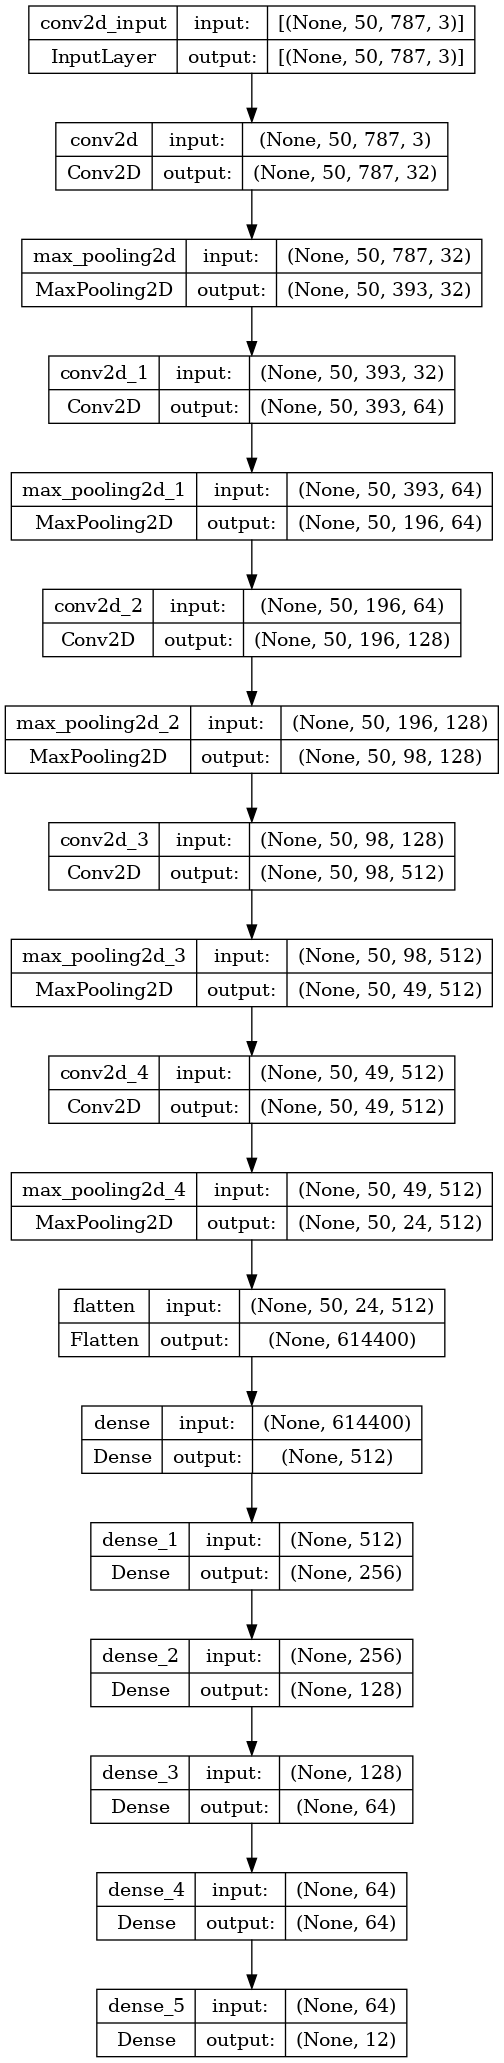

In [17]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras Sequential model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


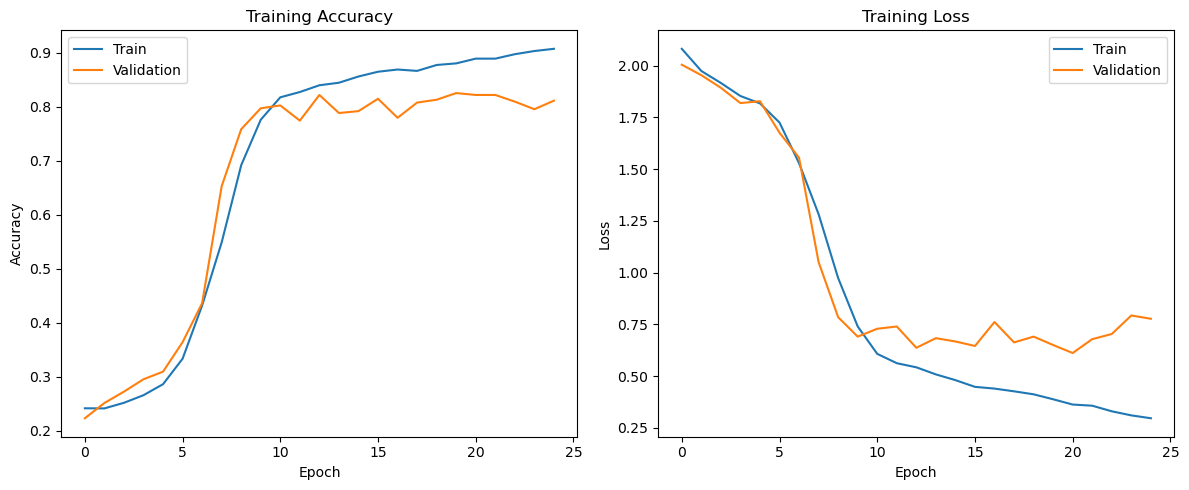

In [19]:
import matplotlib.pyplot as plt

# ... (previous code remains the same)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
